In [ ]:
import os
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype, is_numeric_dtype

Preprocessing

In [ ]:
# authenticate
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
# open worksheet
worksheet = gc.open('Combined_19-21').sheet1

# get_all_values gives a list of rows
rows = worksheet.get_all_values()

# convert to a DataFrame and render
df = pd.DataFrame(rows)
df.columns = df.iloc[0]
df = df.iloc[1:]
df.head()

,Location,Date,Description,Cost,Category
1,Burger King,2019-05-15,Dinner,$2.19,restaurant
2,Dennys,2019-05-17,Late night/early morning food for both Sam and I,$24.76,restaurant
3,Dennys,2019-05-17,Tip,$4.95,restaurant
4,Wawa,2019-05-17,Moving Truck fuel,$27.50,transportation
5,Exxon,2019-05-17,Moving Truck fuel,$78.25,transportation


In [ ]:
# get rid of ',' and '$'
df['Cost'] = df['Cost'].str.replace(',', '', regex=True)
df['Cost'] = df['Cost'].str.replace('$', '', regex=True)

In [ ]:
# define data types for columns
new_df_schema = {
'Location': df['Location'].astype(str),
'Date': pd.to_datetime(df['Date']),
'Description': df['Description'].astype(str),
'Cost': pd.to_numeric(df['Cost'], errors='coerce'),
'Category': df['Category'].astype(str),
}

# update the data types
df = pd.DataFrame(new_df_schema)

In [ ]:
# change tax to misc
df['Category'] = df['Category'].str.replace('tax', 'misc')

In [ ]:
# change clothing to clothes
df['Category'] = df['Category'].str.replace('clothing', 'clothes')

In [ ]:
# change coupons to grocery
df['Category'] = df['Category'].str.replace('coupons', 'grocery')

In [ ]:
# change all descriptions to lowercase
df['Description'] = df['Description'].str.lower()

In [ ]:
df['Location'] = df['Location'].str.replace(" ", "")

In [ ]:
# change description: tax to category: misc
df.loc[df['Description'] == 'tax', 'Category'] = 'misc'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 1 to 2929
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Location     2929 non-null   object        
 1   Date         2928 non-null   datetime64[ns]
 2   Description  2929 non-null   object        
 3   Cost         2928 non-null   float64       
 4   Category     2929 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 114.5+ KB


In [ ]:
df.describe(include='all', datetime_is_numeric=True)

,Location,Date,Description,Cost,Category
count,2929,2928,2929,2928.000000,2929
unique,330,NaN,943,NaN,25
top,Walmart,NaN,tax,NaN,misc
freq,816,NaN,313,NaN,346
mean,NaN,2020-07-14 17:02:57.049180416,NaN,25.391441,NaN
min,NaN,2019-05-15 00:00:00,NaN,-523.810000,NaN
25%,NaN,2019-10-27 00:00:00,NaN,1.760000,NaN
50%,NaN,2020-06-12 00:00:00,NaN,3.660000,NaN
75%,NaN,2021-03-31 00:00:00,NaN,9.880000,NaN
max,NaN,2021-12-31 00:00:00,NaN,4500.000000,NaN


In [ ]:
df.isnull().sum()

Location       0
Date           1
Description    0
Cost           1
Category       0
dtype: int64

In [ ]:
# change Cost NaN to 0
df['Cost'] = df['Cost'].fillna(0)

In [ ]:
df.to_csv('expenses_data1.csv', index=False)

In [ ]:
# new dataframe without negatives or zeros
df_pos = df.copy()

In [ ]:
# get names of indexes for which column Cost is <= 0
indexNames = df_pos[df_pos['Cost'] <= 0].index
# delete these row indexes from dataFrame
df_pos.drop(indexNames , inplace=True)

In [ ]:
# change subcategories to grocery
df_pos['Category'] = df_pos['Category'].replace(dict.fromkeys(['bread','breakfast','canned','condiments','dairy','grains','meat','pasta','produce','snacks'], 'grocery'))

In [ ]:
# split Date into Day, Month, Year
df_pos['Day'] = df_pos['Date'].dt.day.apply(str)
df_pos['Month'] = df_pos['Date'].dt.month_name()
df_pos['Year'] = df_pos['Date'].dt.year.apply(str)
df_pos = df_pos.drop('Date', axis=1)

In [ ]:
df_pos.to_csv('pos_expenses_data1.csv', index=False)

Exploratory Data Analysis

In [ ]:
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2839 entries, 1 to 2929
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Location     2839 non-null   object 
 1   Description  2839 non-null   object 
 2   Cost         2839 non-null   float64
 3   Category     2839 non-null   object 
 4   Day          2839 non-null   object 
 5   Month        2839 non-null   object 
 6   Year         2839 non-null   object 
dtypes: float64(1), object(6)
memory usage: 177.4+ KB


In [ ]:
df_pos.describe(include='all')

,Location,Description,Cost,Category,Day,Month,Year
count,2839,2839,2839.000000,2839,2839,2839,2839
unique,324,924,NaN,15,31,12,3
top,Walmart,tax,NaN,grocery,24,December,2020
freq,815,302,NaN,1479,164,351,1005
mean,NaN,NaN,27.174181,NaN,NaN,NaN,NaN
std,NaN,NaN,183.483647,NaN,NaN,NaN,NaN
min,NaN,NaN,0.020000,NaN,NaN,NaN,NaN
25%,NaN,NaN,1.980000,NaN,NaN,NaN,NaN
50%,NaN,NaN,3.940000,NaN,NaN,NaN,NaN
75%,NaN,NaN,10.000000,NaN,NaN,NaN,NaN


In [ ]:
# create numeric list, category list and small cat list of categories with <15 unique entries
num_list = []
cat_list = []
small_cat_list = []

for column in df_pos:
  if is_numeric_dtype(df_pos[column]):
    num_list.append(column)
  elif is_string_dtype(df_pos[column]):
    cat_list.append(column)

for column in df_pos:
  if len(pd.unique(df_pos[column])) < 15:
    small_cat_list.append(column)

print(num_list)
print(cat_list)
print(small_cat_list)

['Cost']
['Location', 'Description', 'Category', 'Day', 'Month', 'Year']
['Month', 'Year']


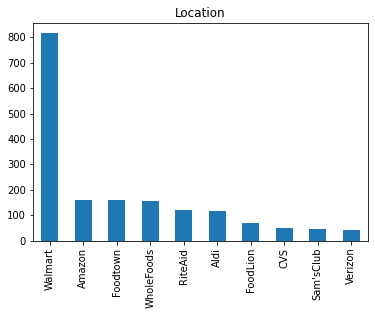

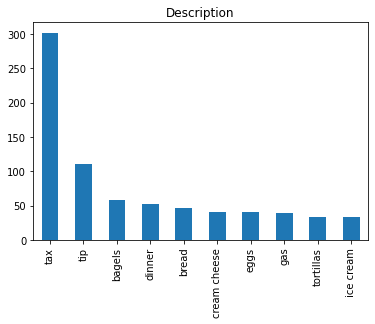

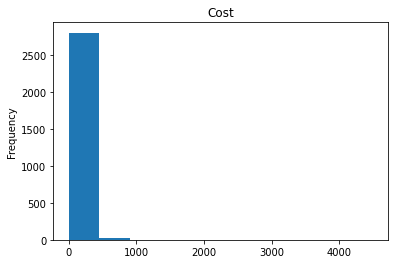

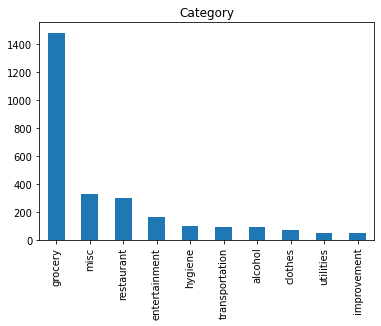

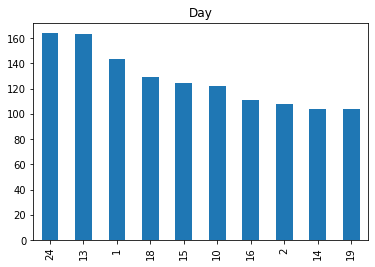

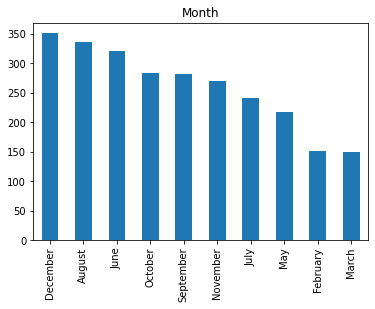

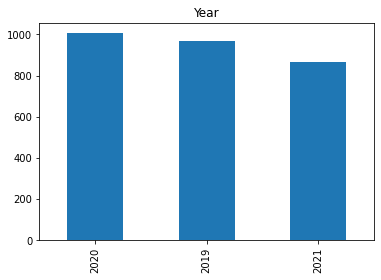

In [ ]:
# bar chart for frequency of categorical variables, histogram for continuous
for column in df_pos:
  plt.figure(column)
  plt.title(column)
  if is_numeric_dtype(df_pos[column]):
    df_pos[column].plot(kind='hist')
  else:
    df_pos[column].value_counts()[:10].plot(kind='bar')

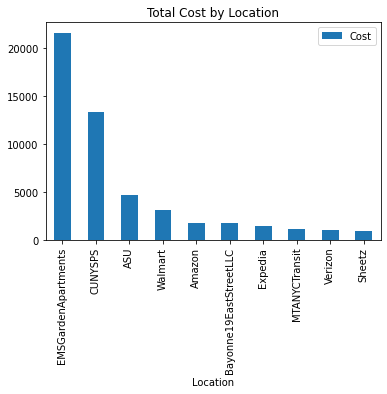

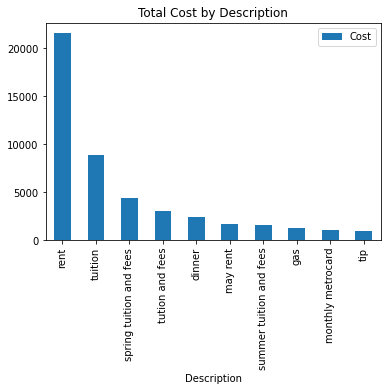

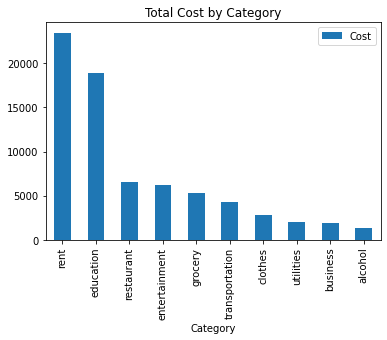

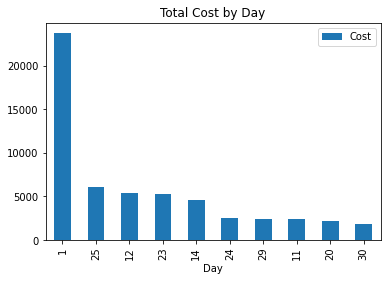

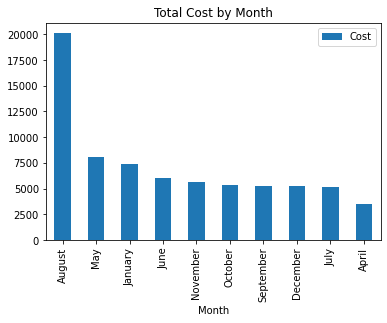

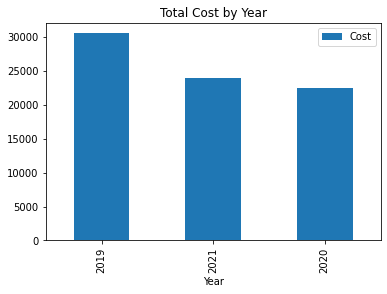

In [ ]:
# bar plot of top 10 by values for each variable by cost 
for column in df_pos:
  if column != 'Cost':
    sum_cost =  df_pos.groupby([column]).sum().reset_index()
    sum_cost = sum_cost.sort_values(by=['Cost'], ascending=False)
    sum_cost[:10].plot(x=column, y='Cost', kind='bar', title='Total Cost by %s' % column)

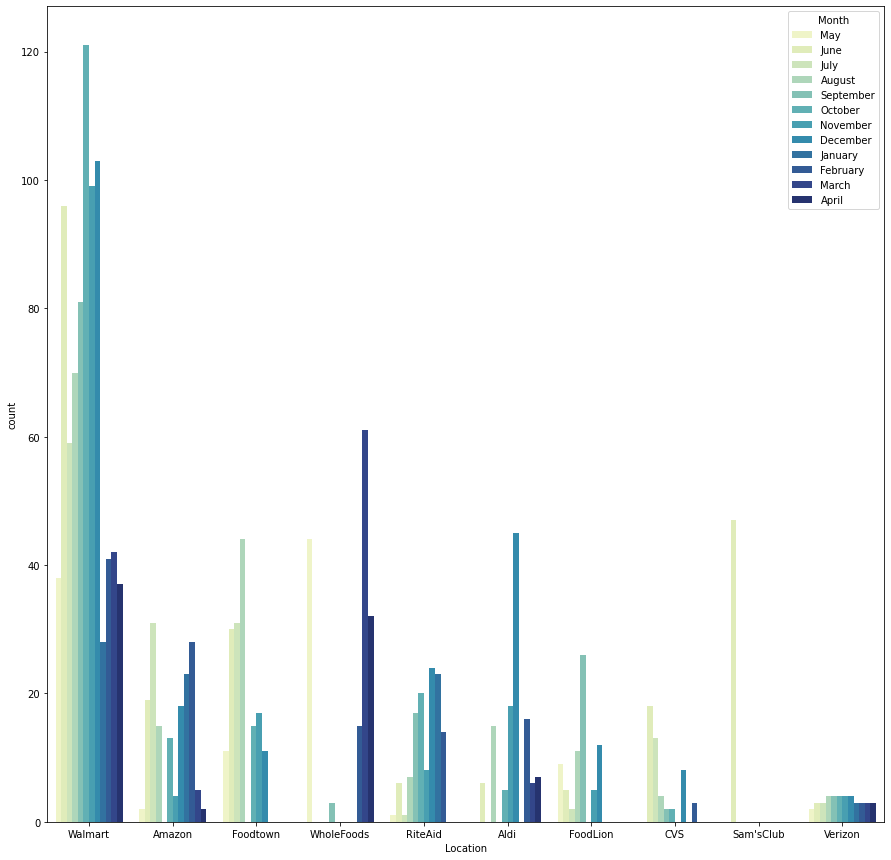

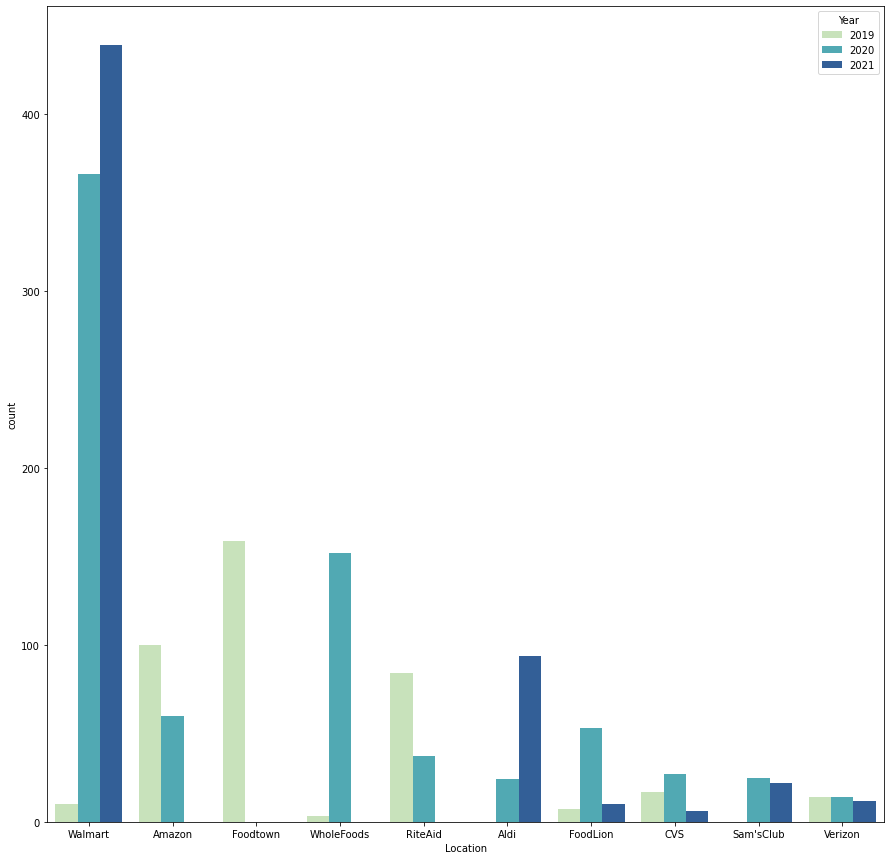

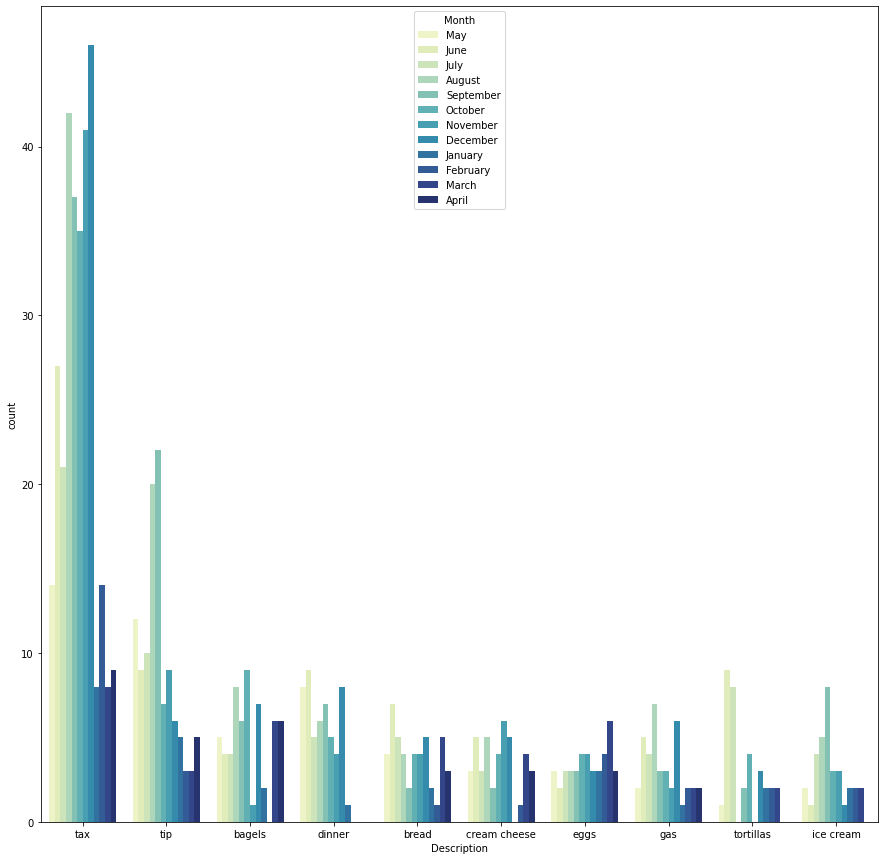

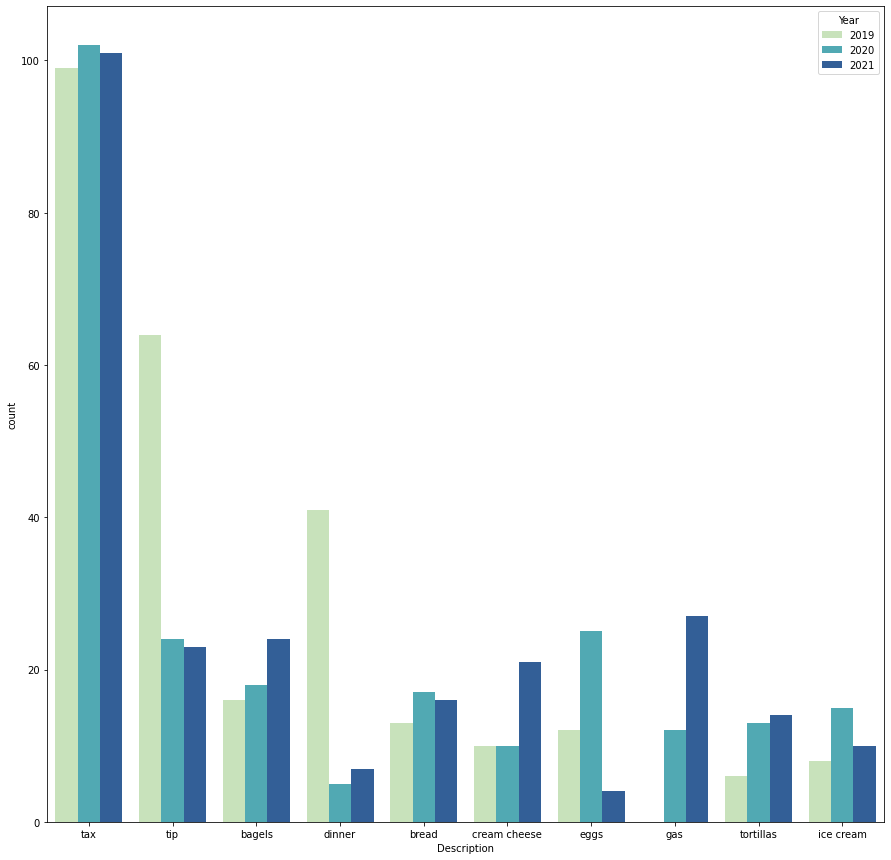

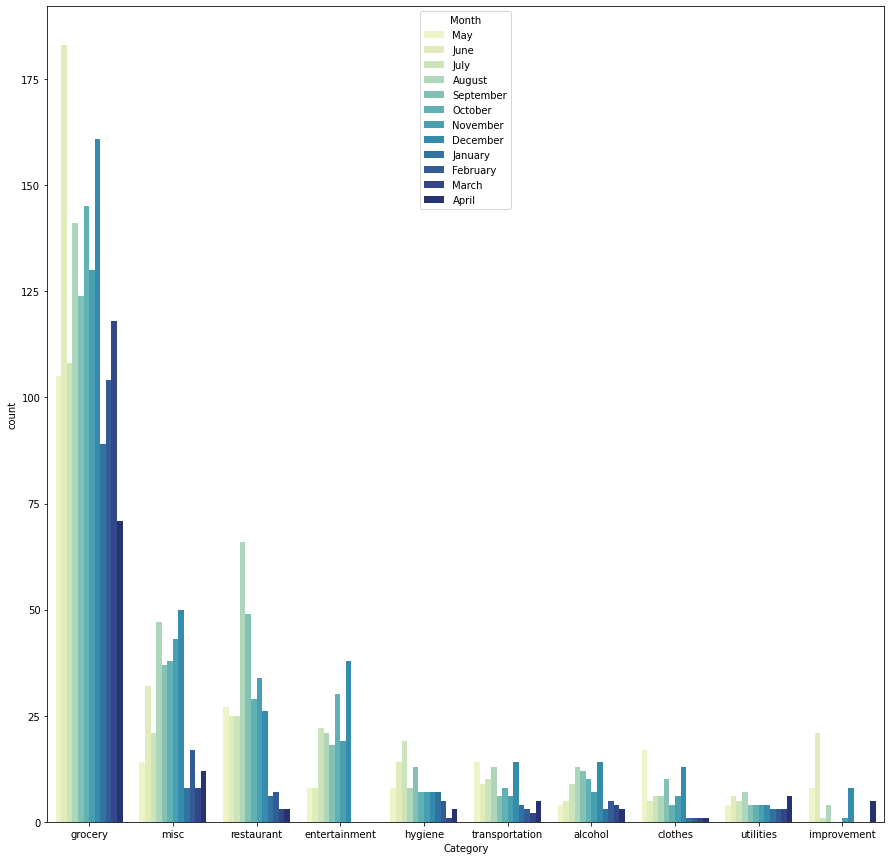

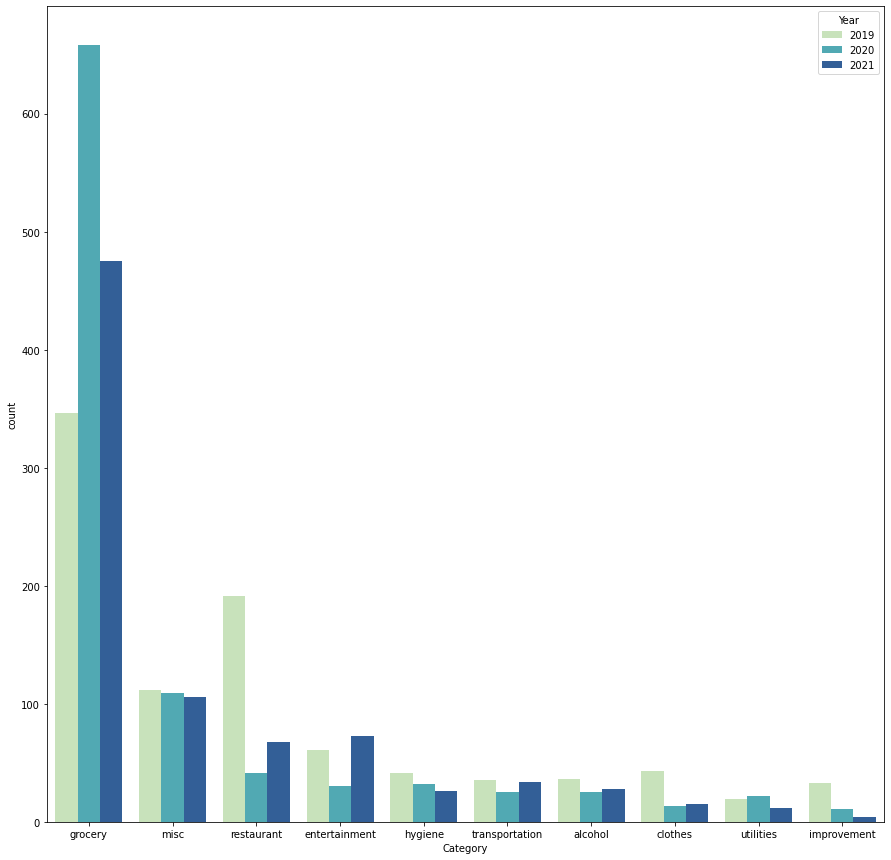

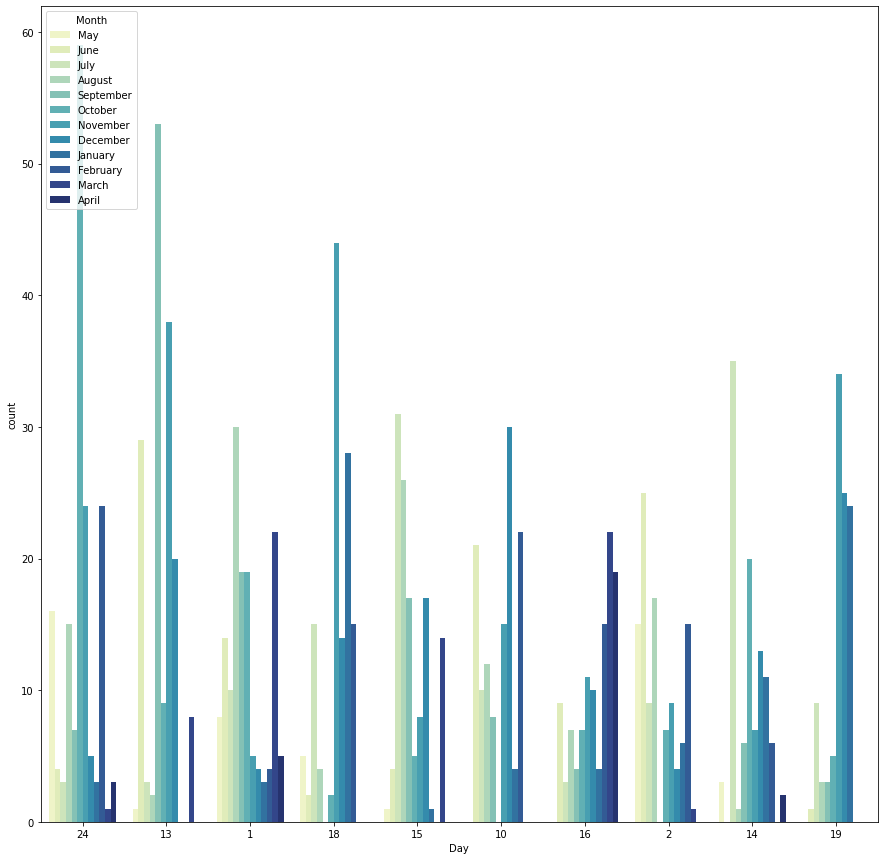

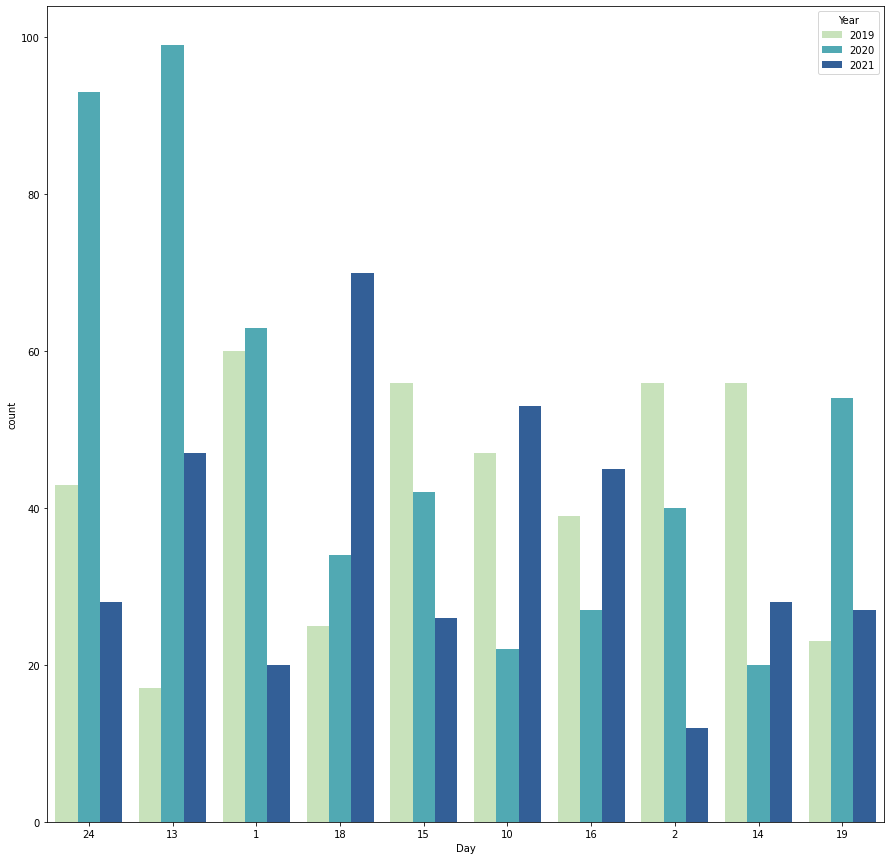

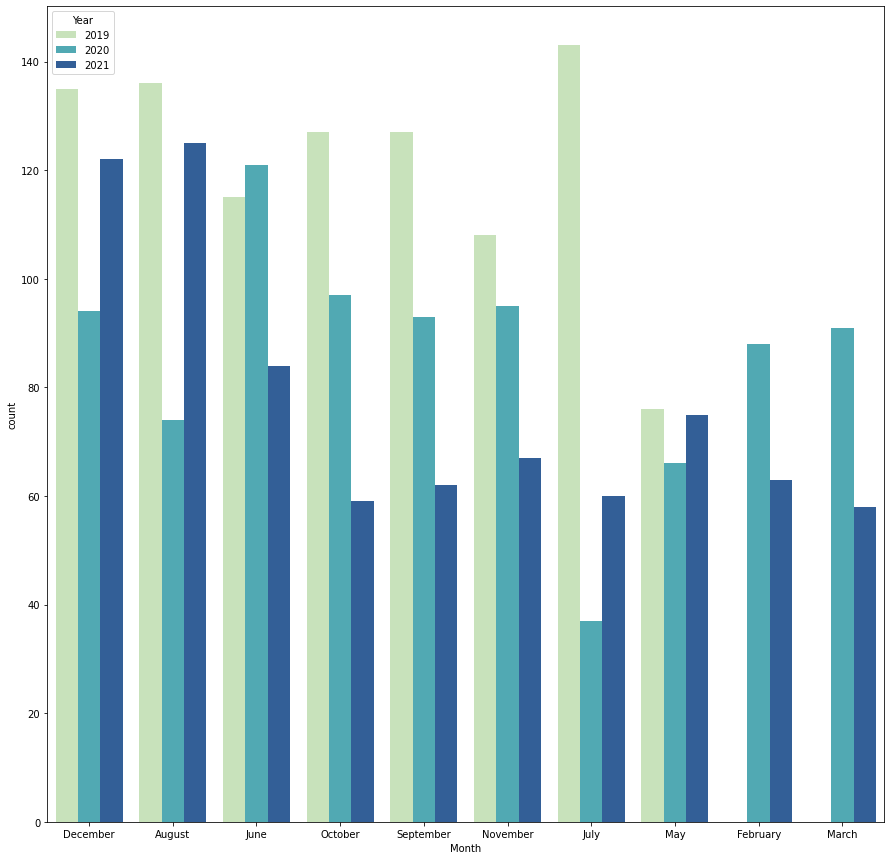

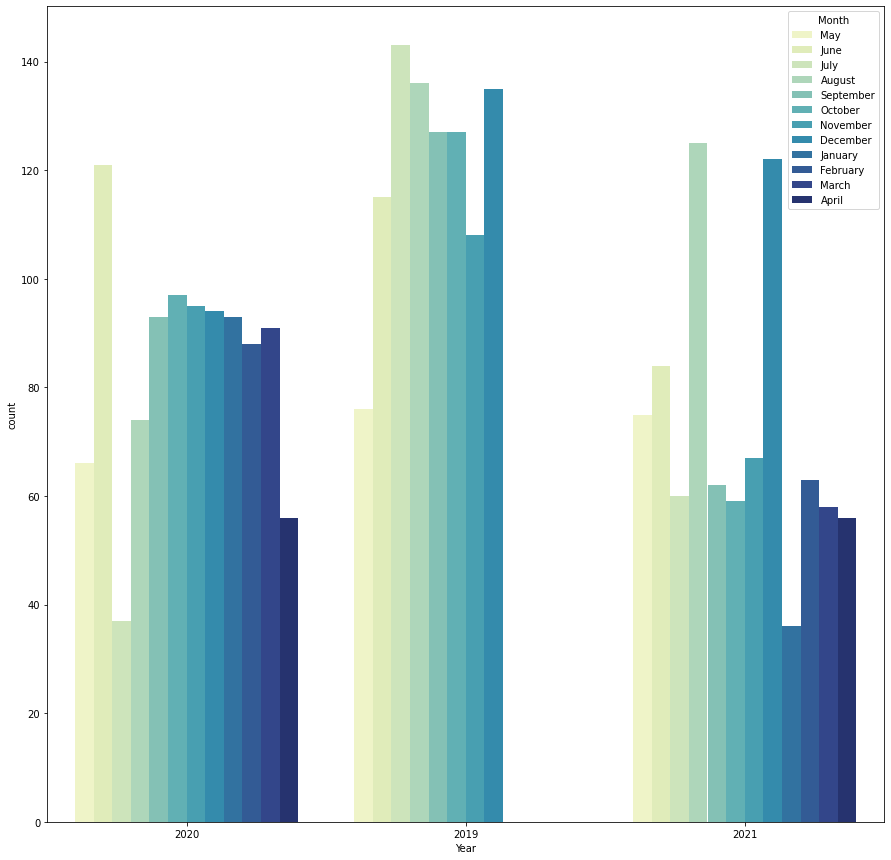

In [ ]:
# grouped bar charts of categorical variables
for i in range(0, len(cat_list)):
  primary_cat = cat_list[i]
  for j in range(0, len(small_cat_list)):
    secondary_cat = small_cat_list[j]
    if secondary_cat != primary_cat:
      plt.figure (figsize = (15,15))
      chart = sns.countplot(
        data = df_pos,
        x = primary_cat, 
        hue = secondary_cat,
        palette = 'YlGnBu',
        order = df_pos[primary_cat].value_counts().iloc[:10].index #show only TOP10
      )

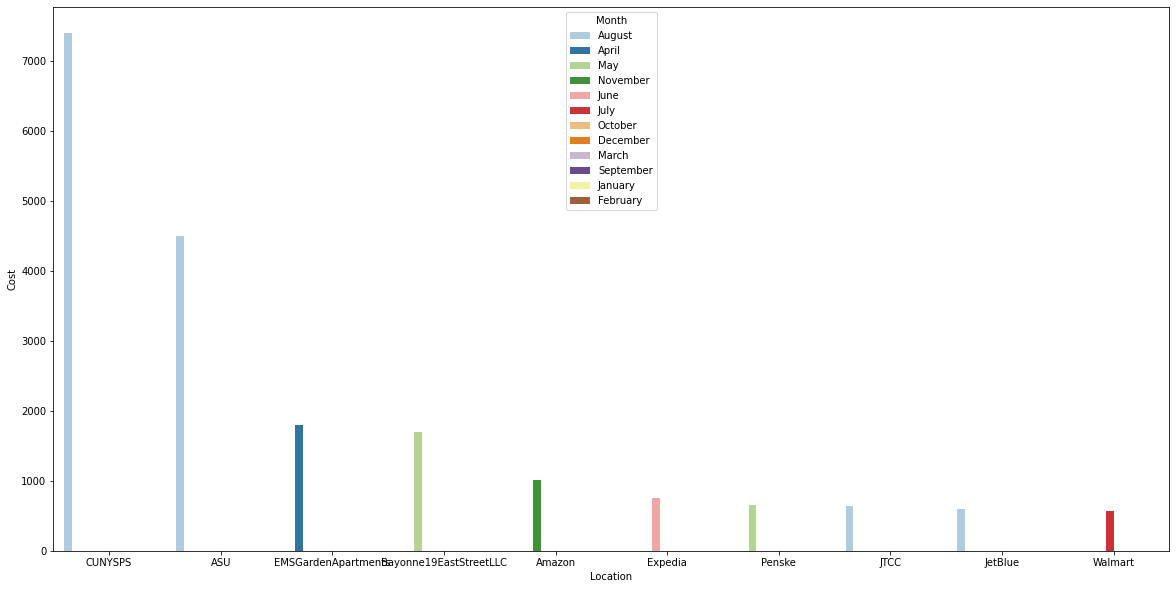

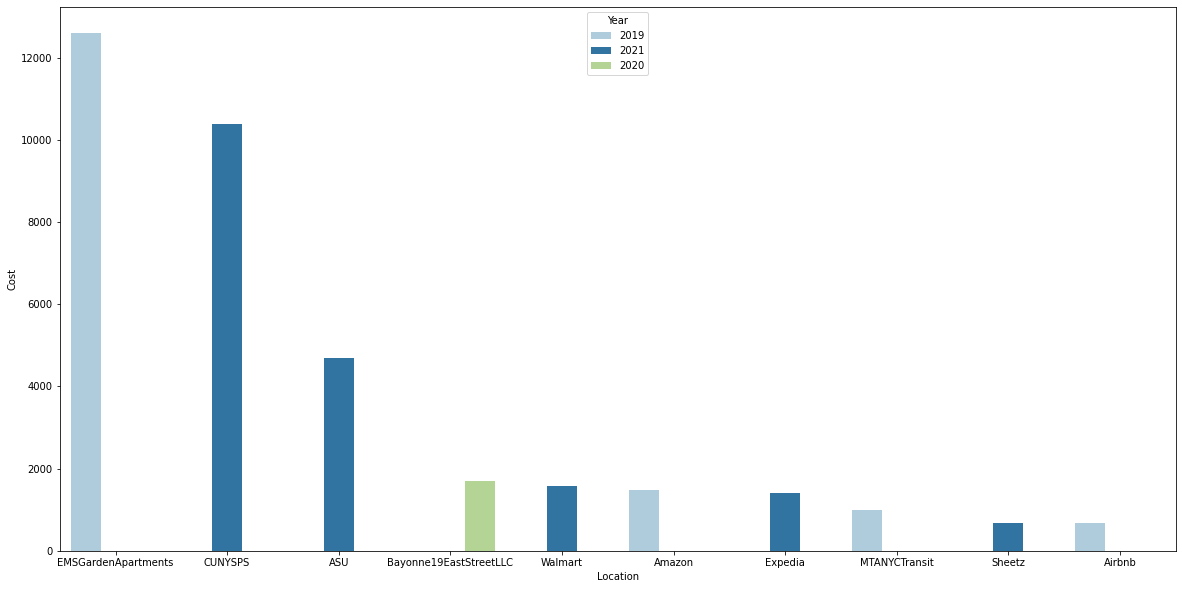

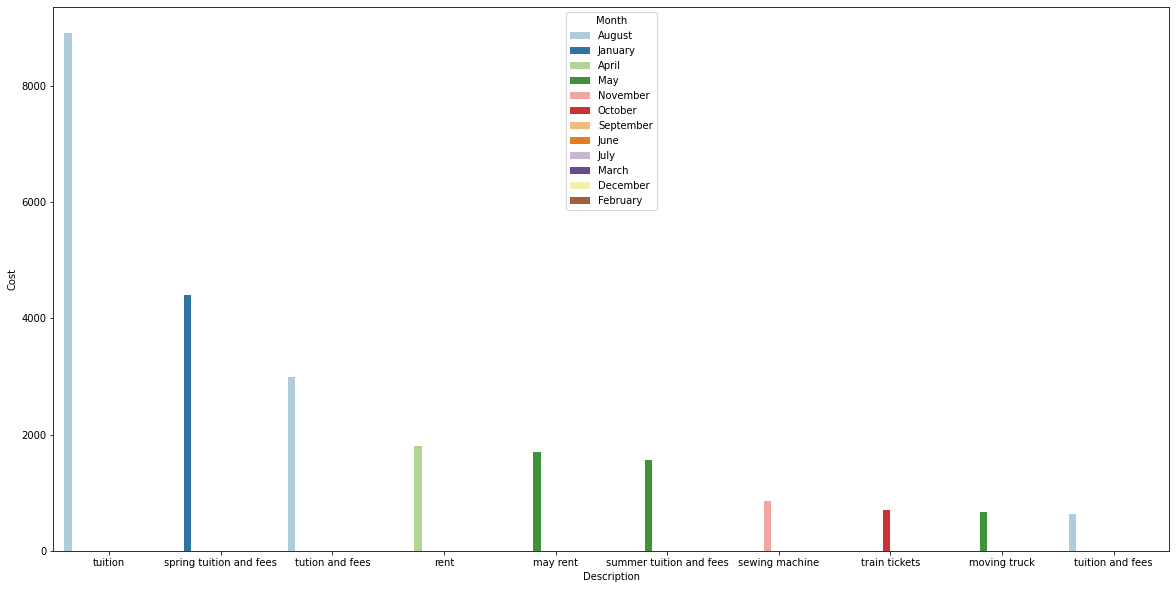

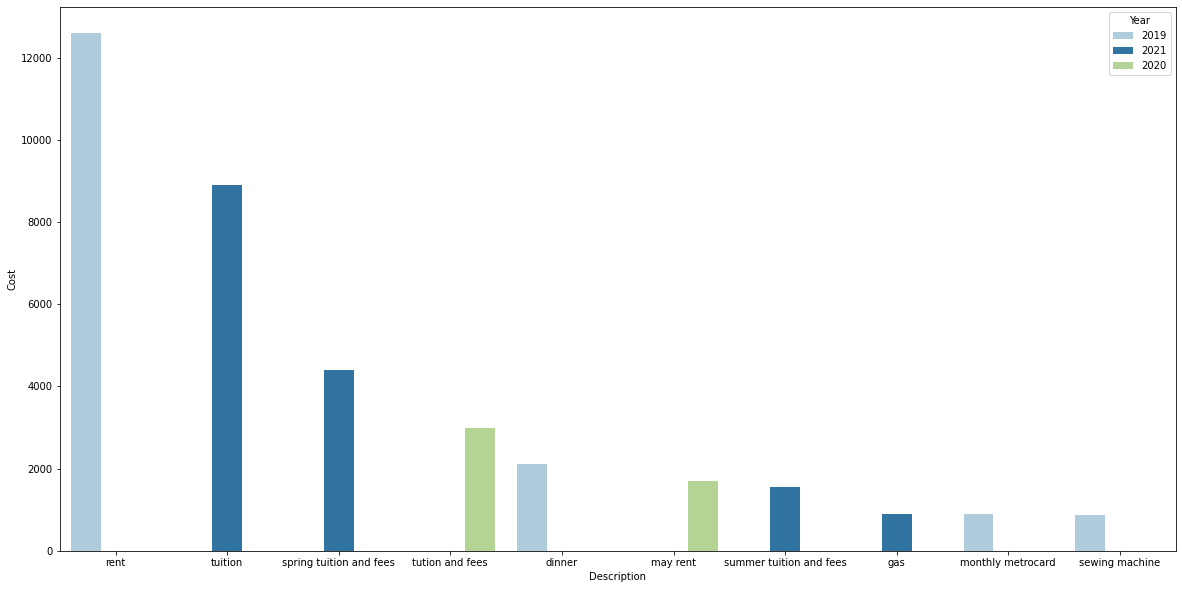

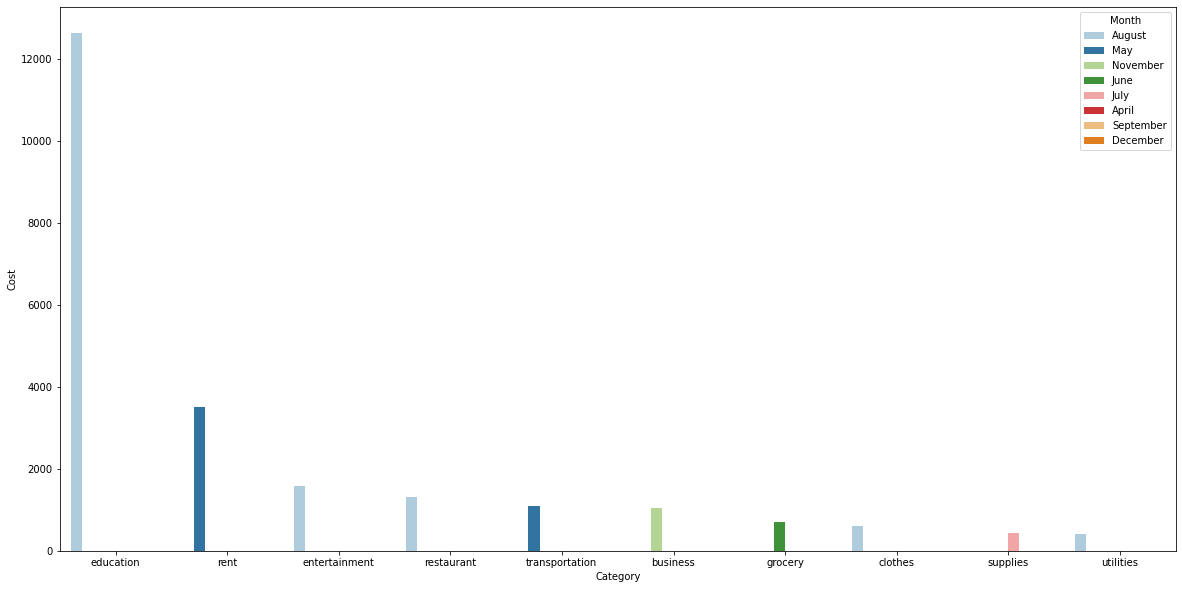

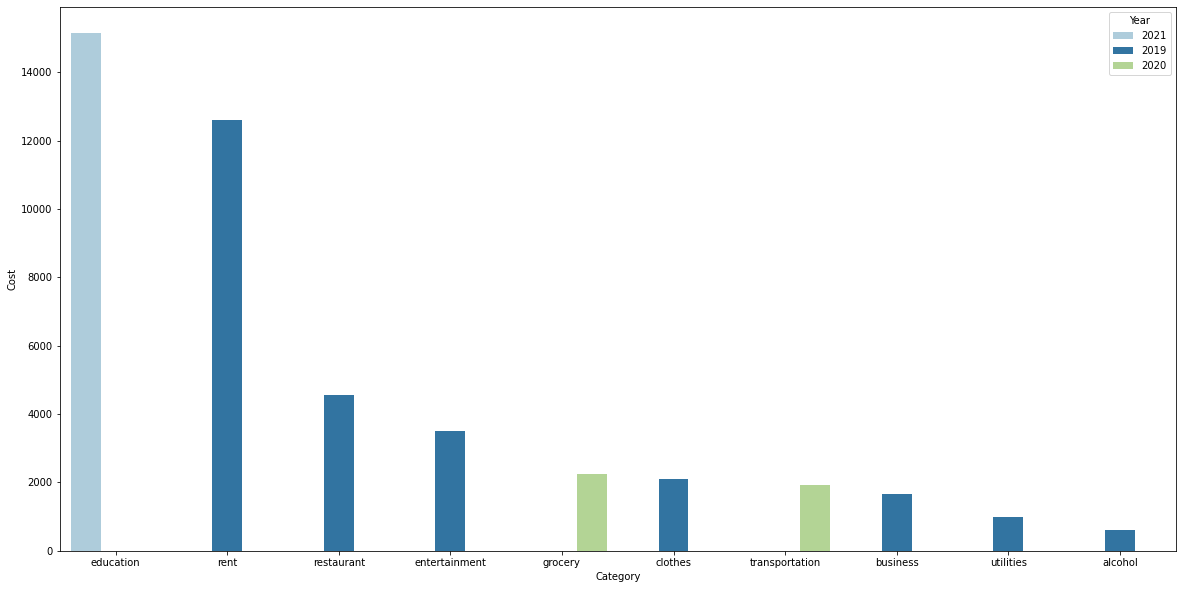

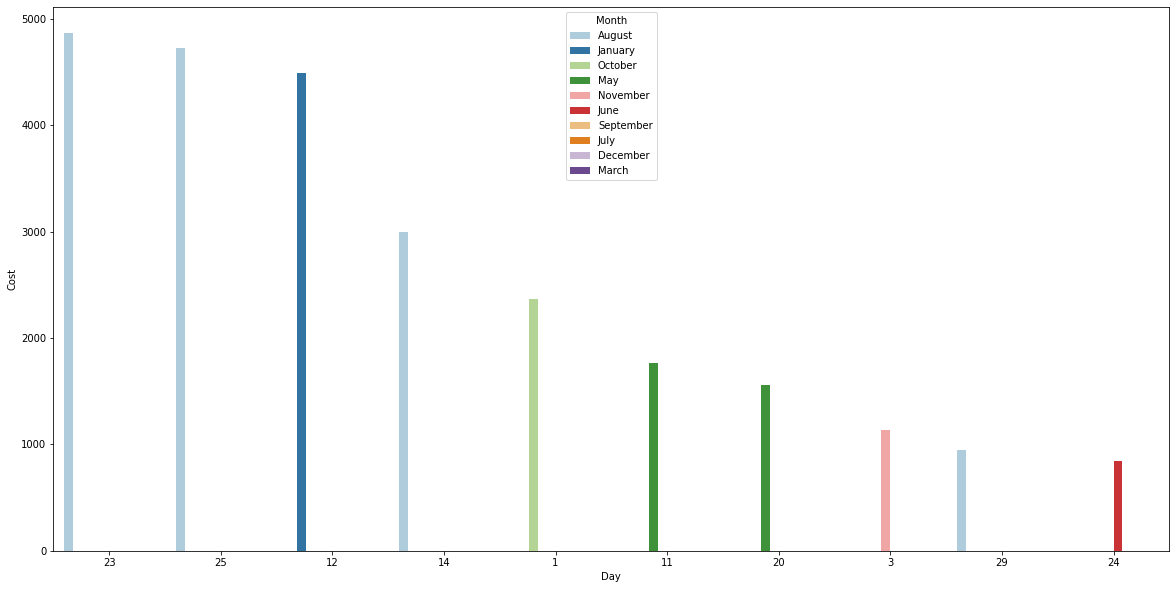

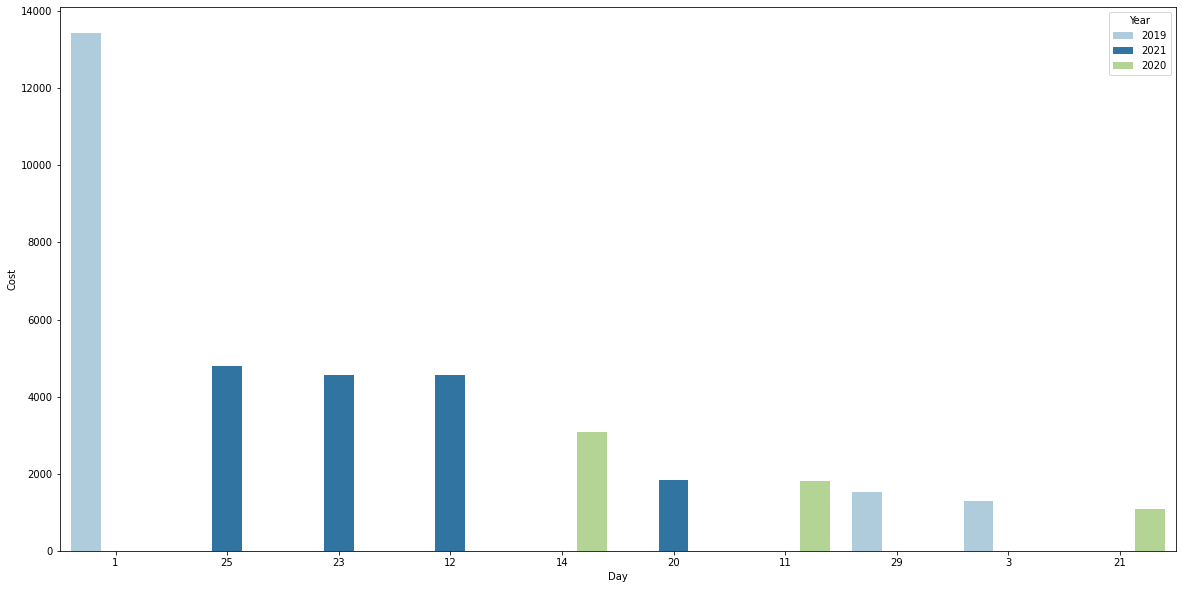

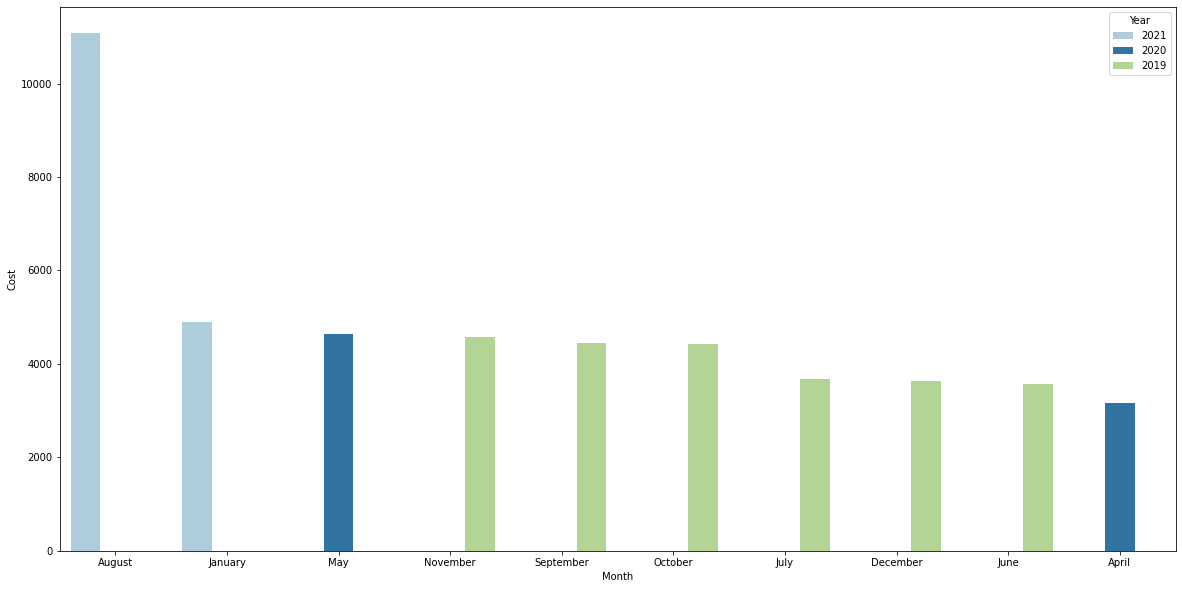

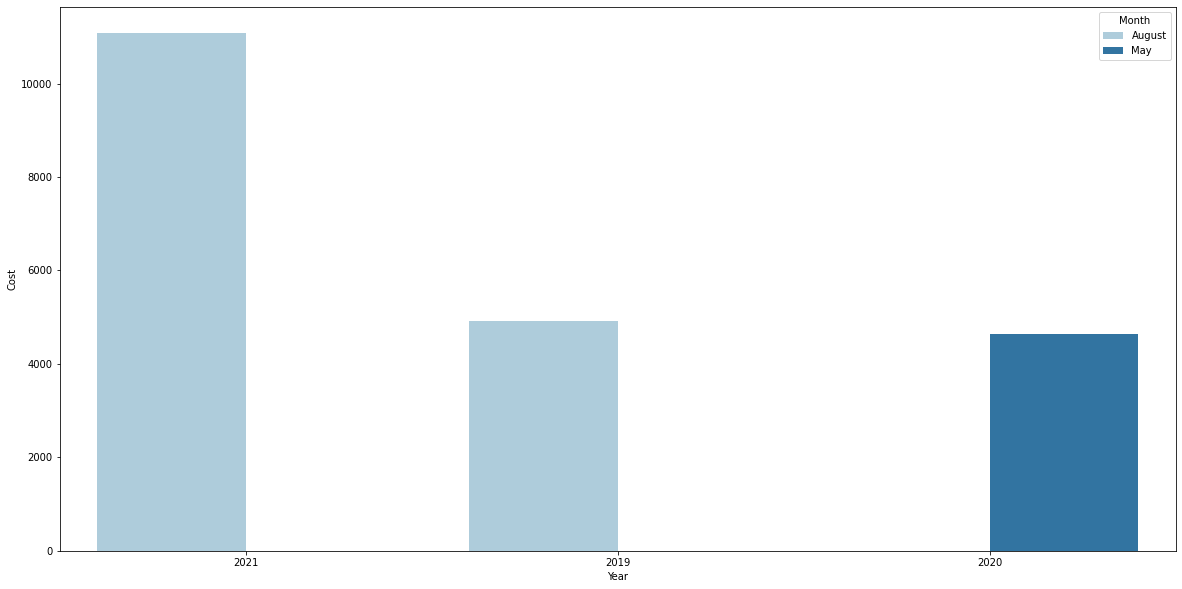

In [ ]:
# bar plot
for i in range(0, len(cat_list)):
  primary_cat = cat_list[i]
  for j in range(0, len(small_cat_list)):
    secondary_cat = small_cat_list[j]
    if secondary_cat != primary_cat:
      plt.figure (figsize = (20,10))
      df_group = df_pos.groupby([primary_cat, secondary_cat]).sum().reset_index()
      df_unique = df_group.loc[df_group.groupby([primary_cat])['Cost'].idxmax()]
      df_sort = df_unique.sort_values(by=['Cost'], ascending=False)
      chart = sns.barplot(
        data = df_sort,
        x = primary_cat,
        y = 'Cost',
        hue = secondary_cat,
        palette = 'Paired',
        order = df_sort[primary_cat][:10] #show only TOP10
      )

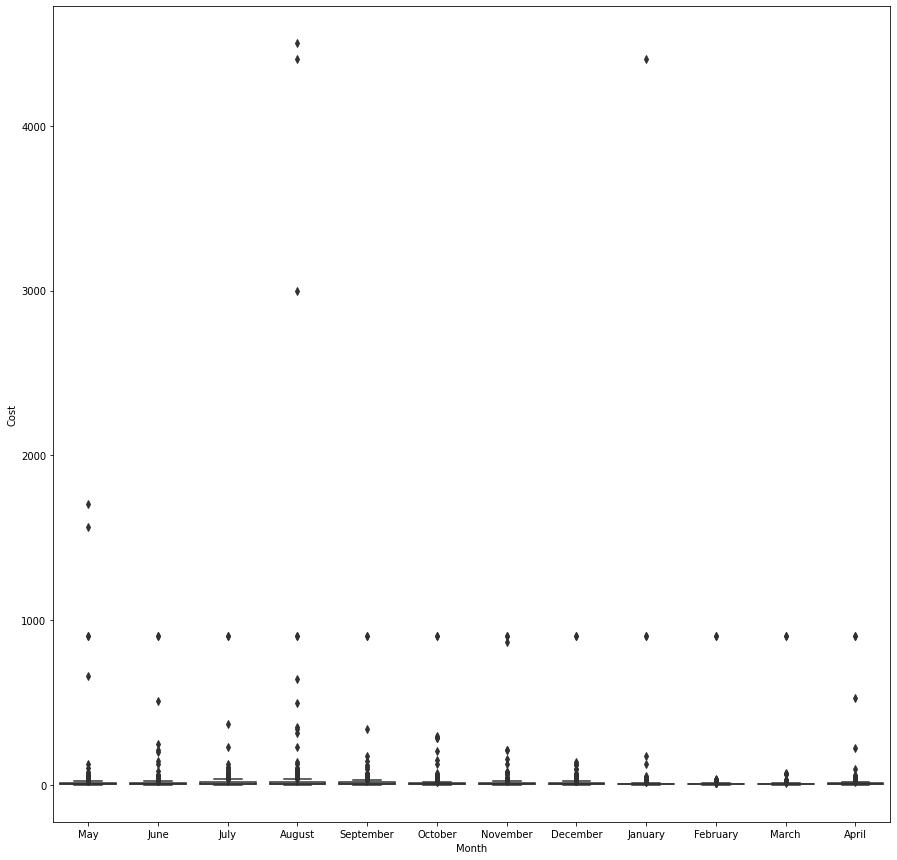

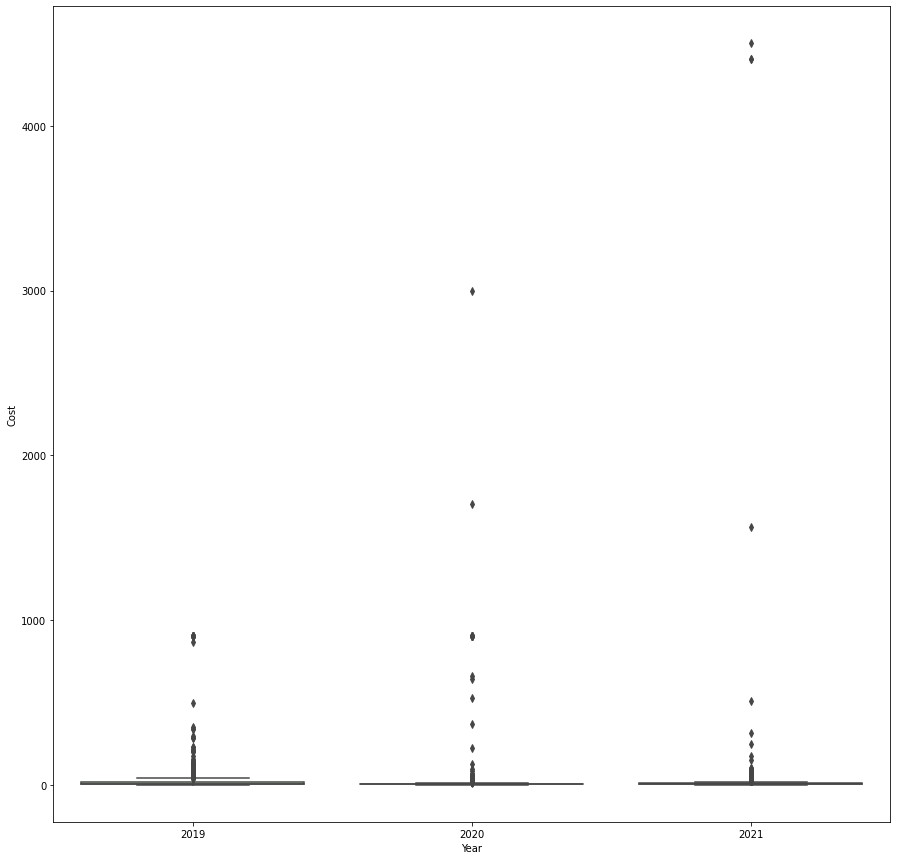

In [ ]:
# box plot
for i in range(0, len(small_cat_list)):
  cat = small_cat_list[i]
  num = df_pos['Cost']
  plt.figure (figsize = (15,15))
  sns.boxplot( x = cat, y = num, data = df_pos, palette = "GnBu")